In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import os

from collections import defaultdict
import cv2
from skimage.io import imread

%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.6f}'.format

import sys

import gym
from gym.wrappers import Monitor
import gym_ple

couldn't import doomish
Couldn't import doom


In [2]:
folder = "data"
images_folder = os.path.join(folder, "images")
labels_folder = os.path.join(folder, "labels")

data = []

for image_name in tqdm_notebook(os.listdir(images_folder)[:1000]):
    image_path = os.path.join(images_folder, image_name)
    label_path = os.path.join(labels_folder, image_name)
    
    image = imread(image_path)[:, :, :3]
    label = imread(label_path)
    
    data.append((image, label))

In [3]:
def score_prediction(pred, label):
    pred_binary = (pred != 0).any(axis=2)
    label_binary = (label == 1) | (label == 2)
    
    intersection = (pred_binary & label_binary).sum()
    union = (pred_binary | label_binary).sum()
    
    return intersection / union if union > 0 else 0.

In [4]:
from croppers import GrabCutCropper, PatternMatchCropper, SemanticSegmentationCropper

cropper = SemanticSegmentationCropper()

def score_one(img_and_label):
    image, label = img_and_label
    pred = cropper.crop_image(image)
    return score_prediction(pred, label)

/home/evgenii/miniconda3/envs/tf_py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2018-06-25 15:03:29,387 Layers 3, features 16, filter size 3x3, pool size: 2x2


INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2018-06-25 15:03:30,447 Restoring parameters from ./unet_trained/model.ckpt
2018-06-25 15:03:30,484 Model restored from file: ./unet_trained/model.ckpt


In [7]:
from multiprocessing import Pool

def score_async(data):
    pool = Pool(20)
    return list(tqdm_notebook(pool.imap_unordered(score_one, data), total=len(data)))

def score_sync(data):
    return list(map(score_one, tqdm_notebook(data)))
    
scores = score_sync(data)

/home/evgenii/miniconda3/envs/tf_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


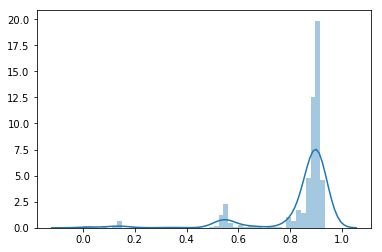

In [8]:
sns.distplot(scores)

In [16]:
def measure_for_threshold(threshold):
    pmc = PatternMatchCropper(threshold)
    
    scores = []
    for image, label in tqdm_notebook(data, leave=False):
        pred = pmc.crop_image(image)
        score = score_prediction(pred, label)

        scores.append(score)
        
    return np.mean(scores)

th_sc = []

for threshold in tqdm_notebook(np.linspace(0.5, 0.8, 20)):
    score = measure_for_threshold(threshold)
    th_sc.append((threshold, score))

In [10]:
np.mean(scores)

0.8368173624692472

In [5]:
from croppers import GrabCutCropper, PatternMatchCropper

cropper = GrabCutCropper()

scores = []
for image, label in tqdm_notebook(data):
    pred = cropper.crop_image(image)
    score = score_prediction(pred, label)

    scores.append(score)

return np.mean(scores)

KeyboardInterrupt: 

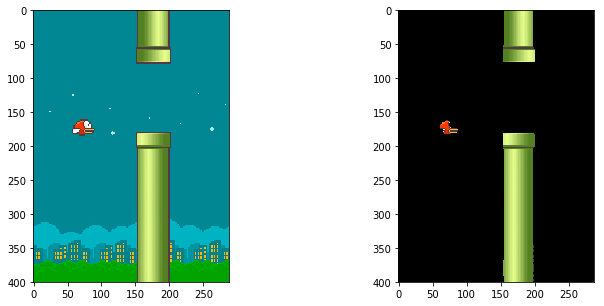

In [19]:
num = 10

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

image, label = data[num]
pred = cropper.crop_image(image)

ax1.imshow(image)
ax2.imshow(pred)

In [11]:
idx = np.where(np.array(scores) < .6)[0]
print(idx)

[  1   2  13  18  22  23  29  32  46  58  59  61  63  69  74  89  93 112
 115 127 141 143 175 185 194 196 197 210 212 225 231 236 248 251 258 269
 282 288 289 292 304 307 315 323 340 347 359 373 382 390 425 428 431 440
 470 498 544 545 546 548 557 560 573 606 610 611 615 618 622 631 632 641
 660 663 670 674 692 697 703 705 712 715 719 723 734 736 753 754 755 763
 765 771 785 807 808 813 815 823 852 867 895 897 900 914 922 933 960 978
 994 996]


In [22]:
t = np.array(scores)

t[t >= .6].mean()

0.8860146900750827